<a href="https://colab.research.google.com/github/mglowacki100/AndrewNG-Coursera/blob/master/Nrai_evaluate_better_sortino_MLJAR_regr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Created by Suraj Parmar

- Numerai: [SurajP](https://numer.ai/surajp)

- Twitter: [@parmarsuraj99](https://twitter.com/parmarsuraj99)


Thanks to [@NJ](https://twitter.com/tasha_jade) and [@MikeP](https://twitter.com/EasyMikeP) for feedbacks.

# Evaluating Financial Machine Learning Models on Numerai

## Don't just submit and wait, evaluate!

A walkthrough to some evaluation metrics you can use for your models. 

This isn't ment to be a `Run All` notebook. I have tried to make this flexible and customizable so that you can adapt this to your workflow.

Hope this helps

You can change to GPU runtime by `Runtime > Change runtime type > GPU > Save`

## 1.0 Loading required libraries 📔 and dataset 🗄️🔽

In [1]:
!pip install numerapi
!pip install catboost;

     |████████████████████████████████| 66.3MB 41kB/s 


In [2]:
!pip install mljar-supervised


     |████████████████████████████████| 81kB 9.0MB/s 
     |████████████████████████████████| 14.5MB 250kB/s 
     |████████████████████████████████| 10.5MB 43.4MB/s 
     |████████████████████████████████| 6.8MB 47.2MB/s 
     |████████████████████████████████| 148.9MB 98kB/s 
     |████████████████████████████████| 1.8MB 40.5MB/s 
     |████████████████████████████████| 66.1MB 71kB/s 
     |████████████████████████████████| 296kB 54.2MB/s 
     |████████████████████████████████| 153kB 60.8MB/s 
     |████████████████████████████████| 63.8MB 44kB/s 
     |████████████████████████████████| 51kB 8.0MB/s 
     |████████████████████████████████| 327kB 52.4MB/s 
     |████████████████████████████████| 225kB 51.3MB/s 
     |████████████████████████████████| 368kB 56.5MB/s 
     |████████████████████████████████| 81kB 10.6MB/s 
     |████████████████████████████████| 61kB 9.9MB/s 
  Created wheel for mljar-supervised: filename=mljar_supervised-0.7.11-cp36-none-any.whl size=107266 sha256=9bac

In [1]:
import os
import gc
import csv
import sys
import glob
import time
from pathlib import Path
from multiprocessing import Pool

import numerapi

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression

In [2]:
napi = numerapi.NumerAPI(verbosity="info")
# download current dataset
napi.download_current_dataset(unzip=True)

current_ds = napi.get_current_round()
latest_round = os.path.join('numerai_dataset_'+str(current_ds))

2020-12-05 22:36:36,995 INFO numerapi.base_api: target file already exists


In [3]:
#TOURNAMENT_NAME = "kazutsugi"
TOURNAMENT_NAME = ""
#TARGET_NAME = f"target_{TOURNAMENT_NAME}"
TARGET_NAME = f"target"
#PREDICTION_NAME = f"prediction_{TOURNAMENT_NAME}"
PREDICTION_NAME = f"prediction"

BENCHMARK = 0
BAND = 0.2

#-----------------------------------------------------

# Submissions are scored by spearman correlation
def score(df):
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df[TARGET_NAME],
        df[PREDICTION_NAME].rank(pct=True, method="first")
    )[0, 1]


# The payout function
def payout(scores):
    return ((scores - BENCHMARK) / BAND).clip(lower=-1, upper=1)


# Read the csv file into a pandas Dataframe
def read_csv(file_path):
    with open(file_path, 'r') as f:
        column_names = next(csv.reader(f))
        dtypes = {x: np.float16 for x in column_names if
                  x.startswith(('feature', 'target'))}
    return pd.read_csv(file_path, dtype=dtypes)

In [4]:
%%time
print("# Loading data...")
# The training data is used to train your model how to predict the targets.
training_data = read_csv(os.path.join(latest_round, "numerai_training_data.csv")).set_index("id")
# The tournament data is the data that Numerai uses to evaluate your model.
tournament_data = read_csv(os.path.join(latest_round, "numerai_tournament_data.csv")).set_index("id")

#example_preds = read_csv(os.path.join(latest_round, "example_predictions_target_kazutsugi.csv")).set_index("id")
example_preds = read_csv(os.path.join(latest_round, "example_predictions.csv")).set_index("id")

validation_data = tournament_data[tournament_data.data_type == "validation"]


# Loading data...
CPU times: user 56 s, sys: 3.14 s, total: 59.1 s
Wall time: 1min 36s


In [5]:
feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")

Loaded 310 features


In [6]:
TRAIN_EVAL_PREFIX = "train"
VAL_EVAL_PREFIX = "val"

## <center>Notebook Flow</center>
<p align="center">
  <img src="https://raw.githubusercontent.com/parmarsuraj99/numerai-guides/master/better_evaluation/images/notebook_flow.png" width=40%>
</p>

---

## <center>Some simple metrics to get started</center>
<p align="center">
  <img src="https://raw.githubusercontent.com/parmarsuraj99/numerai-guides/master/better_evaluation/images/simple_stats.png" width=70%">
</p>


## 2.1 Some added metrics for evaluation 🔬

This is just to get familiar with some simpler metrics. Functions with all the metrics are in the section 2.2

In [7]:
def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

def get_basic_per_era_metrics(df:pd.DataFrame, 
                        isVal=None, 
                        fig_name="per_era_scores.png") -> pd.Series:
    """
    Some metrics related to per-era scores.
    Plots per-era mean correlation with `TARGET_NAME` column
    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Parameters
    ----------
    df_with_preds : pd.DataFrame
        Training or Toutnament DataFrame having predictions assigned
        at `PREDICTION_NAME` column.

    isVal: bool, optional, default:None
    
    fig_name: str, optional, default:per_era_scores.png

    Returns:
    ------
    pd.Series: Pandas Series having 
        (mean, std, %preds<0.5, and %preds<mean(preds), corr w/ example_preds)
    
    """

    prefix=None
    #Some checks for deciding between training and tournament data
    if isVal:
        df = df[df.data_type == "validation"]
        prefix=VAL_EVAL_PREFIX
        print("predicting on validation...")
    else:
        df = df
        prefix=TRAIN_EVAL_PREFIX
        print("predicting on train...")

    #-----------------------------------------------------
    scores = pd.Series(dtype=float)
    preds_ = df[PREDICTION_NAME]
    scores[f"{prefix}_mean"] = preds_.mean()
    scores[f"{prefix}_std_dev"] = preds_.std()

    #-----------------------------------------------------
    #Metric Calculations
    print("getting per era scores")
    era_scores = df.groupby("era").apply(
        lambda x: spearmanr(x[TARGET_NAME], x[PREDICTION_NAME]))
    
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.savefig(f"{prefix}_{fig_name}")
    plt.show()

    #-----------------------------------------------------
    scores[f"{prefix}_mean correlation"] = np.mean(era_scores)
    scores[f"{prefix}_Std. Dev."] = np.std(era_scores)
    scores[f"{prefix}_sharpe"] = np.mean(era_scores)/np.std(era_scores)

    #MG:
    def downside_risk(returns):
      sqr_downside = np.square(np.clip(returns, np.NINF, 0))
      return np.sqrt(np.nanmean(sqr_downside))
    
    scores[f"{prefix}_downside_risk"] = downside_risk(era_scores)
    scores[f"{prefix}_sortino"] = np.mean(era_scores)/downside_risk(era_scores)

    print(scores)
    del era_scores
    del preds_
    
    gc.collect()
    return scores


In [8]:
def get_all_metrics(model, 
                    feature_names:list=feature_names, 
                    fig_name="per_era_scores")->pd.Series:

    #training_preds = model.predict(training_data[feature_names].values)
    training_preds = model.predict(training_data[feature_names]) #MG
    #training_data[PREDICTION_NAME] = np.array(training_preds).reshape(-1,1)
    training_data[PREDICTION_NAME] = training_preds

    #else:
    #tournament_preds = model.predict(tournament_data[feature_names].values)
    tournament_preds = model.predict(tournament_data[feature_names]) #MG
    #tournament_data[PREDICTION_NAME] = np.array(tournament_preds).reshape(-1,1)
    tournament_data[PREDICTION_NAME] = tournament_preds

    #del training_preds
    #del tournament_preds

    print("evaluating on training data...")
    tr_per_era_scores = get_basic_per_era_metrics(training_data, isVal=False, fig_name=fig_name)
    #gc.collect()

    print("evaluating on validation data...")
    val_per_era_scores = get_basic_per_era_metrics(tournament_data, isVal=True, fig_name=fig_name)
    #gc.collect()

    return pd.concat([
                      tr_per_era_scores, val_per_era_scores,
                      ])



In [9]:
from supervised.automl import AutoML # mljar-supervised


2020-12-05 22:38:16,365 INFO numexpr.utils: NumExpr defaulting to 2 threads.
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


### Creating some models 🤖

In [10]:
models = dict()

#Linear model
lin_reg = LinearRegression()
models["lin_reg"] = lin_reg


models["mljar_reg"] = AutoML(mode="Compete",
                                 total_time_limit=3*60,
                                 ml_task='regression'
                                 )

#del lin_reg
#del nn_model

#gc.collect()

### Training our models⚙️

In [11]:
for model_name in models:
    print(f"Fitting {model_name}...")

    if "mljar_reg" in model_name:
        models[model_name].fit(training_data[feature_names].astype(float), training_data[TARGET_NAME].astype(float))
    else:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values)

    gc.collect()

Fitting lin_reg...
Fitting mljar_reg...
AutoML directory: AutoML_9
The task is regression with evaluation metric rmse
AutoML will use algorithms: ['Decision Tree', 'Random Forest', 'Extra Trees', 'LightGBM', 'Xgboost', 'CatBoost', 'Neural Network', 'Nearest Neighbors']
AutoML will stack models
AutoML will ensemble availabe models
AutoML steps: ['adjust_validation', 'simple_algorithms', 'default_algorithms', 'not_so_random', 'golden_features', 'insert_random_feature', 'features_selection', 'hill_climbing_1', 'hill_climbing_2', 'ensemble', 'stack', 'ensemble_stacked']
* Step adjust_validation will try to check up to 1 model
1_DecisionTree rmse 0.222529 trained in 14.71 seconds
* Step simple_algorithms will try to check up to 1 model
2_DecisionTree rmse 0.22251 trained in 16.98 seconds
* Step default_algorithms will try to check up to 6 models
3_Default_Xgboost rmse 0.222226 trained in 103.89 seconds
4_Default_LightGBM rmse 0.222285 trained in 67.98 seconds
Skip not_so_random because of t

### Evaluating models 🔬


----lin_reg----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


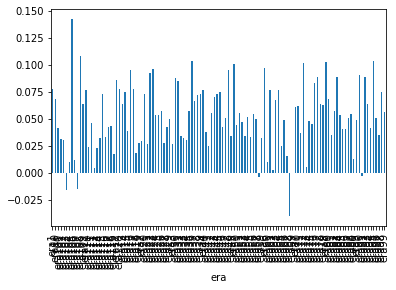

train_mean                 0.500004
train_std_dev              0.011704
train_mean correlation     0.052274
train_Std. Dev.            0.030311
train_sharpe               1.724583
train_downside_risk        0.004142
train_sortino             12.620288
dtype: float64
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


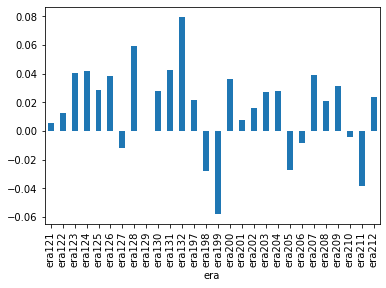

val_mean                0.500001
val_std_dev             0.011691
val_mean correlation    0.016143
val_Std. Dev.           0.029660
val_sharpe              0.544276
val_downside_risk       0.015310
val_sortino             1.054446
dtype: float64

----mljar_reg----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


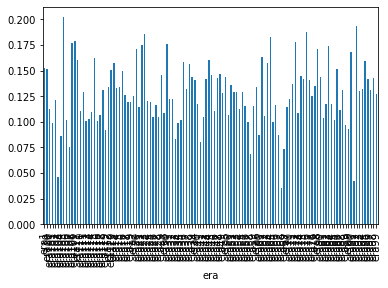

divide by zero encountered in double_scalars


train_mean                0.499977
train_std_dev             0.011230
train_mean correlation    0.127434
train_Std. Dev.           0.030891
train_sharpe              4.125278
train_downside_risk       0.000000
train_sortino                  inf
dtype: float64
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


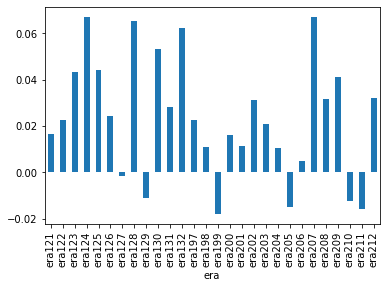

val_mean                0.500497
val_std_dev             0.011208
val_mean correlation    0.023357
val_Std. Dev.           0.025390
val_sharpe              0.919902
val_downside_risk       0.006174
val_sortino             3.782783
dtype: float64
CPU times: user 1min 17s, sys: 4.65 s, total: 1min 21s
Wall time: 1min 3s


In [12]:
%%time
all_model_metrics = dict()
for model_name in models:
    
    print(f"\n----{model_name}----")
    model_metrics = get_all_metrics(models[model_name], feature_names, fig_name = f"{model_name}.png")
    all_model_metrics[model_name] = model_metrics

    gc.collect()


In [13]:
metric_df = pd.DataFrame.from_dict(all_model_metrics)
metric_df

,lin_reg,mljar_reg
train_mean,0.500004,0.499977
train_std_dev,0.011704,0.011230
train_mean correlation,0.052274,0.127434
train_Std. Dev.,0.030311,0.030891
train_sharpe,1.724583,4.125278
train_downside_risk,0.004142,0.000000
train_sortino,12.620288,inf
val_mean,0.500001,0.500497
val_std_dev,0.011691,0.011208
val_mean correlation,0.016143,0.023357



- **`val_mean_correlation`** suggests how much your predictions are correlated to targets across `era`
- **`val_sharpe`** (mean/std) is for higher mean with lower std. dev.
- **`tournament_corr_example_preds`** shows how much your predictions are correlated with `example_predictions` (which have shown very good performance)

As you can see, Neural Net is showing better performance here based on these metrics. Now, let's compare Neural Net with default CatBoost model on more metrics




---

## <center>Metrics used here</center>
<p align="center">
  <img src="https://raw.githubusercontent.com/parmarsuraj99/numerai-guides/master/better_evaluation/images/all_metrics.png" width=100%">
</p>

## 2.2 Expanding the vision with more metrics 🔭

---



Do check out [More Metrics for ya](https://forum.numer.ai/t/more-metrics-for-ya/636) for community discussion

In [10]:
TRAIN_EVAL_PREFIX = "train"
VAL_EVAL_PREFIX = "val"

#Some evaluation metrics
def ar1(x):
    return np.corrcoef(x[:-1], x[1:])[0,1]

def autocorr_penalty(x):
    n = len(x)
    p = ar1(x)
    return np.sqrt(1 + 2*np.sum([((n - i)/n)*p**i for i in range(1,n)]))

def smart_sharpe(x):
    return np.mean(x)/(np.std(x, ddof=1)*autocorr_penalty(x))

def numerai_sharpe(x):
    return ((np.mean(x) - 0.010415154) / np.std(x)) * np.sqrt(12)

def spearmanr(target, pred):
    return np.corrcoef(
        target,
        pred.rank(pct=True, method="first")
    )[0, 1]

#################MG:
#MG:
def downside_risk(x):
    sqr_downside = np.square(np.clip(x, np.NINF, 0))
    return np.sqrt(np.nanmean(sqr_downside))

def sortino(x):
  return np.mean(x)/downside_risk(x)    


#-----------------------------------------------------
def get_baisc_per_era_metrics(df:pd.DataFrame, 
                        isVal=None, 
                        fig_name="per_era_scores.png") -> pd.Series:
    """
    Some metrics related to per-era scores.
    Plots per-era mean correlation with `TARGET_NAME` column

    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Parameters
    ----------
    df_with_preds : pd.DataFrame
        Training or Toutnament DataFrame having predictions assigned
        at `PREDICTION_NAME` column.

    isVal: bool, optional, default:None
        Indication of DataFrame having Validation data. However, the 
        function checks for this is `isVal=None`. Saves checking time!
    
    fig_name: str, optional, default:per_era_scores.png
        Name for per-era correlation graph to be saved with extension.
        prefix will be added to the file name based on `data_type`.
    Returns:
    ------
    pd.Series: Pandas Series having per-era metriccs
    
    """

    prefix=None
    scores = pd.Series(dtype=float)

    preds_ = df[PREDICTION_NAME]
    #Some checks for deciding between training and tournament data
    if isVal:
        scores["tournament_corr_example_preds"] = spearmanr(preds_, example_preds[PREDICTION_NAME])
        df = df[df.data_type == "validation"]
        prefix=VAL_EVAL_PREFIX
        print("predicting on validation...")
    else:
        df = df
        prefix=TRAIN_EVAL_PREFIX
        print("predicting on train...")

    #-----------------------------------------------------

    #Metric Calculations
    print("getting per era scores")
    era_scores = df.groupby("era").apply(
        lambda x: spearmanr(x[TARGET_NAME], x[PREDICTION_NAME]))
    
    era_scores.sort_index(inplace=True)
    era_scores.plot(kind="bar")
    print("performance over time")
    plt.savefig(f"{prefix}_{fig_name}")
    plt.show()

    #-----------------------------------------------------
    
    scores[f"{prefix}_mean"] = preds_.mean()
    scores[f"{prefix}_std_dev"] = preds_.std()
    scores[f"{prefix}_less_than_half"] = (preds_<0.5).mean()
    scores[f"{prefix}_less_than_mean"] = (preds_<preds_.mean()).mean()

    scores[f"{prefix}_autocorrelation"] = ar1(era_scores)
    scores[f"{prefix}_mean correlation"] = np.mean(era_scores)
    scores[f"{prefix}_Median Correlation"] = np.median(era_scores)
    scores[f"{prefix}_Variance"] = np.var(era_scores)
    scores[f"{prefix}_Std. Dev."] = np.std(era_scores)
    scores[f"{prefix}_sharpe"] = np.mean(era_scores)/np.std(era_scores)
    scores[f"{prefix}_smart sharpe"] = smart_sharpe(era_scores)
    scores[f"{prefix}_Numerai sharpe"] = numerai_sharpe(era_scores)
    
    #MG:
    scores[f"{prefix}_downside_risk"] = downside_risk(era_scores)
    scores[f"{prefix}_sortino"] = sortino(era_scores)


    print(scores)
    del era_scores
    del preds_
    gc.collect()
    return scores


In [11]:
#inspired from https://forum.numer.ai/t/more-metrics-for-ya/636 (you should definitely check out)
#and https://github.com/numerai/example-scripts/blob/master/era_boosting_example.ipynb
#and help from `MikeP`

def neutralize(df, columns, by, proportion=1.0):
    scores = df[columns]
    exposures = df[by].values
    
    # constant column to make sure the series is completely neutral to exposures
    exposures = np.hstack((exposures, np.array([np.mean(scores)] * len(exposures)).reshape(-1, 1)))
    gc.collect()
    scores = scores - proportion * exposures.dot(np.linalg.pinv(exposures).dot(scores))
    gc.collect()
    return scores / scores.std()


def calculate_feature_exposure(df, feature_names) -> list:
    exposures = []
    for feature_name in feature_names:
        exposures.append(spearmanr(df[feature_name], df[PREDICTION_NAME]))
        
    max_feat_exposure = np.max(np.abs(exposures))
    square_sum_feature_exposure = np.sum([e**2 for e in exposures])
    feature_exposure = np.std(exposures)

    #print(max_feat_exposure, square_sum_feature_exposure)

    return [feature_exposure, max_feat_exposure, square_sum_feature_exposure]


def get_more_metrics(df, feature_names, isVal=None) -> pd.Series:
    """
    more metrics at: https://forum.numer.ai/t/more-metrics-for-ya/636

    Returns basic stats about predictions in PREDICTION_NAME columns.
    It checks for training or tournament and validation predictions

    Args:
    ------
    df (pd.DataFrame): Training or Tournament DataFrame after assigning predictions
    feature_names (list): List of features to use for neutralization. (Here, all)
    isVal (bool): Boolean suggesting that df contains validation_data

    Returns:
    ------
    pd.Series: Pandas Series having 
        (var, feature_neutral_mean, feat_exposure, max_feat_exposure, 
        square_sum_feature_exposure, max_drawdown)
    """

    more_metrics = pd.Series(dtype=float)
    metric_prefix=None
    assert PREDICTION_NAME in df.columns

    if isVal is None:
        isVal = "validation" in df["data_type"].unique() #max CPU times: user 65.1 ms

    print(isVal)
    if isVal:
        df = df[df["data_type"]=="validation"]
        metric_prefix = VAL_EVAL_PREFIX
    else:
        metric_prefix = TRAIN_EVAL_PREFIX

    assert metric_prefix is not None

    #-----------------------------------------------------

    #per-era scores
    """
    per-era scores
    """
    print("predicting per-era scores...")
    scores_per_era = df.groupby("era").apply(
        lambda df: spearmanr(df[PREDICTION_NAME], df[TARGET_NAME]))
    
    more_metrics[f"{metric_prefix}_var"] = scores_per_era.std()

    #-----------------------------------------------------
    
    #Neutralize
    #This takes a significant amount of memory for calculation
    print(df.shape)
    print("Neutralizing...")
    df[f"neutral_{PREDICTION_NAME}"] = neutralize(df, PREDICTION_NAME, feature_names)
    feature_neutral_mean = df.groupby("era").apply(
        lambda x: spearmanr(x["neutral_"+PREDICTION_NAME].values, x[TARGET_NAME])).mean()

    more_metrics[f"{metric_prefix}_feature_neutral_mean"] = feature_neutral_mean
    gc.collect()

    #-----------------------------------------------------
    print("Calculating Feature Exposure...")
    feature_exposure, max_feat_exposure, square_sum_feature_exposure = calculate_feature_exposure(df, feature_names)

    more_metrics[f"{metric_prefix}_feat_exposure"] = feature_exposure
    more_metrics[f"{metric_prefix}_max_feat_exposure"] = max_feat_exposure
    more_metrics[f"{metric_prefix}_square_sum_feature_exposure"] = square_sum_feature_exposure


    #-----------------------------------------------------
    print("Drawdown...")
    rolling_max = (scores_per_era+1).cumprod().rolling(window=100, min_periods=1).max()
    daily_value = (scores_per_era+1).cumprod()
    max_drawdown = (rolling_max - daily_value).max()

    more_metrics[f"{metric_prefix}_max_drawdown"] = max_drawdown

    return more_metrics

In [12]:
def get_all_metrics(model, 
                    feature_names:list=feature_names, 
                    fig_name="per_era_scores")->pd.Series:

    #training_preds = model.predict(training_data[feature_names].values)
    training_preds = model.predict(training_data[feature_names])
    #training_data[PREDICTION_NAME] = np.array(training_preds).reshape(-1,1)
    training_data[PREDICTION_NAME] = training_preds

    tournament_preds = model.predict(tournament_data[feature_names])
    tournament_data[PREDICTION_NAME] = tournament_preds

    #del training_preds
    #del tournament_preds

    print("evaluating on training data...")
    tr_per_era_scores = get_baisc_per_era_metrics(training_data, isVal=False, fig_name=fig_name)
    #tr_more_metrics = get_more_metrics(training_data, feature_names ,isVal=False)
    #gc.collect()

    print("evaluating on validation data...")
    val_per_era_scores = get_baisc_per_era_metrics(tournament_data, isVal=True, fig_name=fig_name)
    #val_more_metrics = get_more_metrics(tournament_data, feature_names ,isVal=True)
    #gc.collect()
    return pd.concat([
                      tr_per_era_scores, val_per_era_scores,
    #                  tr_more_metrics, val_more_metrics,
                      ])
    

### Creating some models 🤖

In [13]:
models = dict()

#CatBoost Regressor
cat_reg_params = {
    'task_type': 'GPU'
    }
cat_regressor = CatBoostRegressor(**cat_reg_params)
models["cat_reg"] = cat_regressor

#Neural Net
nn_model = tf.keras.models.Sequential([
                                       tf.keras.layers.Input(shape=(310,)),
                                       tf.keras.layers.Dense(64, activation="relu"),
                                       tf.keras.layers.Dense(1, activation="sigmoid")
])
nn_model.compile(loss="mse", optimizer="adam", metrics = [tf.keras.metrics.RootMeanSquaredError()])

#models["keras_mlp_simple"] = nn_model

models["mljar_reg_60"] = AutoML(mode="Compete",
                                 total_time_limit=15*60,
                                 ml_task='regression',
                                 algorithms= ['LightGBM']
                                 )


del cat_regressor
del nn_model
gc.collect()

142

### Training our models⚙️

In [14]:
for model_name in models:
    print(f"Fitting {model_name}...")

    if "keras" in model_name:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values, 
             batch_size=512, 
             epochs=40,
             validation_data=(validation_data[feature_names].values, validation_data[TARGET_NAME].values),
             )
    if "mljar_reg_60" in model_name:
        models[model_name].fit(training_data[feature_names].astype(float), training_data[TARGET_NAME].astype(float))
    else:
        models[model_name].fit(training_data[feature_names].values, training_data[TARGET_NAME].values)

    gc.collect()

Fitting cat_reg...
Learning rate set to 0.089182
0:	learn: 0.2232612	total: 21ms	remaining: 21s
1:	learn: 0.2232562	total: 35.8ms	remaining: 17.9s
2:	learn: 0.2232490	total: 51.4ms	remaining: 17.1s
3:	learn: 0.2232443	total: 66.3ms	remaining: 16.5s
4:	learn: 0.2232395	total: 81.9ms	remaining: 16.3s
5:	learn: 0.2232343	total: 97.9ms	remaining: 16.2s
6:	learn: 0.2232302	total: 114ms	remaining: 16.2s
7:	learn: 0.2232217	total: 129ms	remaining: 16s
8:	learn: 0.2232177	total: 144ms	remaining: 15.8s
9:	learn: 0.2232110	total: 159ms	remaining: 15.8s
10:	learn: 0.2232053	total: 175ms	remaining: 15.8s
11:	learn: 0.2232012	total: 192ms	remaining: 15.8s
12:	learn: 0.2231975	total: 207ms	remaining: 15.8s
13:	learn: 0.2231938	total: 227ms	remaining: 16s
14:	learn: 0.2231835	total: 241ms	remaining: 15.8s
15:	learn: 0.2231798	total: 253ms	remaining: 15.6s
16:	learn: 0.2231761	total: 266ms	remaining: 15.4s
17:	learn: 0.2231709	total: 278ms	remaining: 15.2s
18:	learn: 0.2231654	total: 290ms	remaining: 

In [1]:
import psutil
def get_size(bytes, suffix="B"):
    factor = 1024
    for unit in ["", "K", "M", "G", "T", "P"]:
        if bytes < factor:
            return f"{bytes:.2f}{unit}{suffix}"
        bytes /= factor
print("="*40, "Memory Information", "="*40)
svmem = psutil.virtual_memory()
print(f"Total: {get_size(svmem.total)}") ; print(f"Available: {get_size(svmem.available)}")
print(f"Used: {get_size(svmem.used)}") ; print(f"Percentage: {svmem.percent}%")

======================================== Memory Information ========================================
Total: 12.72GB
Available: 11.94GB
Used: 554.62MB
Percentage: 6.1%


### Evaluating models 🔭


----cat_reg----
evaluating on training data...
predicting on train...
getting per era scores
performance over time


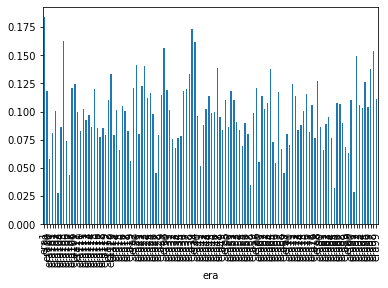

divide by zero encountered in double_scalars


train_mean                   0.499998
train_std_dev                0.008079
train_less_than_half         0.501598
train_less_than_mean         0.501489
train_autocorrelation        0.163366
train_mean correlation       0.097508
train_Median Correlation     0.098793
train_Variance               0.000878
train_Std. Dev.              0.029634
train_sharpe                 3.290434
train_smart sharpe           2.782620
train_Numerai sharpe        10.180894
train_downside_risk          0.000000
train_sortino                     inf
dtype: float64
evaluating on validation data...
predicting on validation...
getting per era scores
performance over time


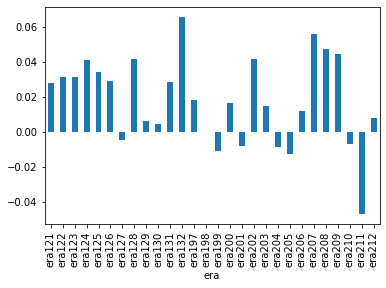

tournament_corr_example_preds    0.543738
val_mean                         0.500055
val_std_dev                      0.008086
val_less_than_half               0.501303
val_less_than_mean               0.504508
val_autocorrelation              0.288500
val_mean correlation             0.017928
val_Median Correlation           0.017403
val_Variance                     0.000613
val_Std. Dev.                    0.024765
val_sharpe                       0.723923
val_smart sharpe                 0.534290
val_Numerai sharpe               1.050862
val_downside_risk                0.009802
val_sortino                      1.829034
dtype: float64

----mljar_reg_60----


In [ ]:
%%time
all_model_metrics = dict()
for model_name in models:
    
    print(f"\n----{model_name}----")
    model_metrics = get_all_metrics(models[model_name], feature_names, fig_name = f"{model_name}.png")
    all_model_metrics[model_name] = model_metrics
    
    #gc.collect()
    

In [ ]:
metric_df = pd.DataFrame.from_dict(all_model_metrics)
metric_df

### Let's Compare these models aginst `example_predictions`

In [ ]:
tournament_data[PREDICTION_NAME] = example_preds.values.reshape(-1, 1)

example_val_per_era_scores = get_baisc_per_era_metrics(tournament_data, isVal=True, fig_name="example_preds")
example_val_more_metrics = get_more_metrics(tournament_data, feature_names ,isVal=True)

example_preds_metrics = pd.concat([example_val_per_era_scores, example_val_more_metrics])

In [ ]:
metric_df["example_preds"] = example_preds_metrics

In [ ]:
metric_df

In [ ]:
#Go ahead and use these to improve your models

## Model for your submission

Left as an exercise to the reader 😉

▶️ Visit [An easy guide to “The hardest data science tournament on the planet”](https://towardsdatascience.com/a-guide-to-the-hardest-data-science-tournament-on-the-planet-748f46e83690) to get started with how to make your submissions directly from colab.



In [ ]:
#Train and evaluate your model for submission


## Uploading predictions using your API keys 🚀

In [ ]:
tournament_data[PREDICTION_NAME].to_csv(f"{TOURNAMENT_NAME}_{current_ds}_submission.csv")

In [ ]:
# NameOfYourAI
public_id = "YourKeys"
secret_key = "YourKeys"
model_id = "YourKeys"
napi = numerapi.NumerAPI(public_id=public_id, secret_key=secret_key)

In [ ]:
submission_id = napi.upload_predictions(f"{TOURNAMENT_NAME}_{current_ds}_submission.csv", model_id=model_id)



---


# Whats Next? 💭
 - **Customize this according to your workflow**
 - Read about [MMC](https://docs.numer.ai/tournament/metamodel-contribution)
 - Connect on [RocketChat](https://community.numer.ai/) or [Forum](https://forum.numer.ai/)
 - Take some help from [analysis_and_tips.ipynb](https://github.com/numerai/example-scripts/blob/master/analysis_and_tips.ipynb) notebook
 - Read this topic on forum about  metrics - ["More Metrics for ya" ](https://forum.numer.ai/t/more-metrics-for-ya/636)
 - Read and try to join the [weekly Office Hours](https://docs.numer.ai/office-hours-with-arbitrage/office-hours-recaps/ohwa-1) \(I was interviewed [OHwA S02E10](https://docs.numer.ai/office-hours-with-arbitrage/office-hours-recaps-season-2/ohwa-s02e10) 😃)


Found any mistake? Please let me know.